## **Importing Libraries**

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import VisionTransformer
from transformers import DistilBertConfig, DistilBertModel

## **Utility Functions**

In [2]:
def set_requires_grad(models, requires_grad):
    for model in models:
        for p in model.parameters():
            p.requires_grad = requires_grad

def _l2_norm(x):
    return x / torch.linalg.vector_norm(x, ord=2, dim=1, keepdim=True)

## **Modality Encoder (Image)**

**Hidden Dimension** of the vision transformer refers to the **size of the patch** accepted by it. For instance, for the ViT - B transformer, the acceptabe patch size if 16 x 16 and for RGB images it makes the embedding size as **16 x 16 x 3 = 768**.

Further, a Linear Layer converts the Embedding into a Logit, hence converting the shape from hidden_dim to embed_dim

Also, the ViT Transformer has a **\<cls> token** for classification tasks that is **not useful** for our application, hence we use an Identity function to nullify the token. 

In [ ]:
class Image_Encoder(nn.Module):                                             # Defining an Image Encoder class which inherits attributes from nn.Module class
    
    # Constructor method which helps with initialization 
    def __init__(self, img_size, patch_size, n_layers,
                 n_heads, hidden_dim, mlp_dim, embed_dim):       

        # Lets child call upon constructor of the parent class 
        super().__init__()

        self.img_size = img_size
        self.embed_dim = embed_dim
        self.model = VisionTransformer(image_size = img_size, patch_size = patch_size,
                                    num_layers = n_layers, num_heads = n_heads,
                                    hidden_dim = hidden_dim, mlp_dim = mlp_dim)
        
        self.model.heads = nn.Identity                            
        self.img_proj = nn.Linear(hidden_dim, embed_dim)                    # Converting the 768 size embeding to a logit

    def forward(self, X):
        X = self.model()                                                    # Gets the output from the Vision Transformer, i.e, Vector Embeds 
        X = self.img_proj(X)                                                # Converts the Embedding into a logit 
        return X

## **Text Encoder**

Similar to the Modality Encoder, the Text Encoder also converts text into Embeddings. Before sending the Logits into the Multi Modal LLM, we must **ensure that the Logits from both the Image and Text must be of the same size**, only then the Matrix formation will be possible. \
\
This projectiom to match the dimensions of the Image Logit is done by the text_proj function.\
\
token_ids are the **tokens that are present in the text** given to us, these are generated by some type of tokenizer. These tokens are passed into the DistilBert model, which produces embeddings corresponding to them. These embeddings are projected accordingly before being sent to the LLM. \
\
Furthermore, an attention mask is used to ensure that some of the **tokens which arent to be considered** arent considered in the final matrix.

In [ ]:
class Text_Encoder(nn.Module):

    def __init__(self, vocab_size, max_len, n_layers,
                 n_heads, hidden_dim, mlp_dim, embed_dim):
        
        super().__init__()

        self.max_len = max_len
        self.model = DistilBertModel(
            DistilBertConfig(
                vocab_size = vocab_size, max_position_embeddings = max_len,
                n_heads = n_heads, n_layers = n_layers, dim = hidden_dim,
                hidden_dim = mlp_dim, attention_dropout = 0.1
            )
        )

        self.text_proj = nn.Linear(hidden_dim, embed_dim)                               # Projects the Embedding into a Logit vector of the same size as Image Logit

    def forward(self, token_ids, attn_mask):
        X = self.model(input_ids = token_ids, attention_mask = attn_mask)

    

### **CLIP Function**

Here we will call the Encoder functions and then create the Similarity Matrix from the embeddings. We will use this matrix then to calculate the loss using Cross Entropy Loss.

To calculate the Loss Function, we make use of the **CLIP contrastive loss method**. Where the diagonal elements of the similarity matrix must be maximized and all others must be minimized.

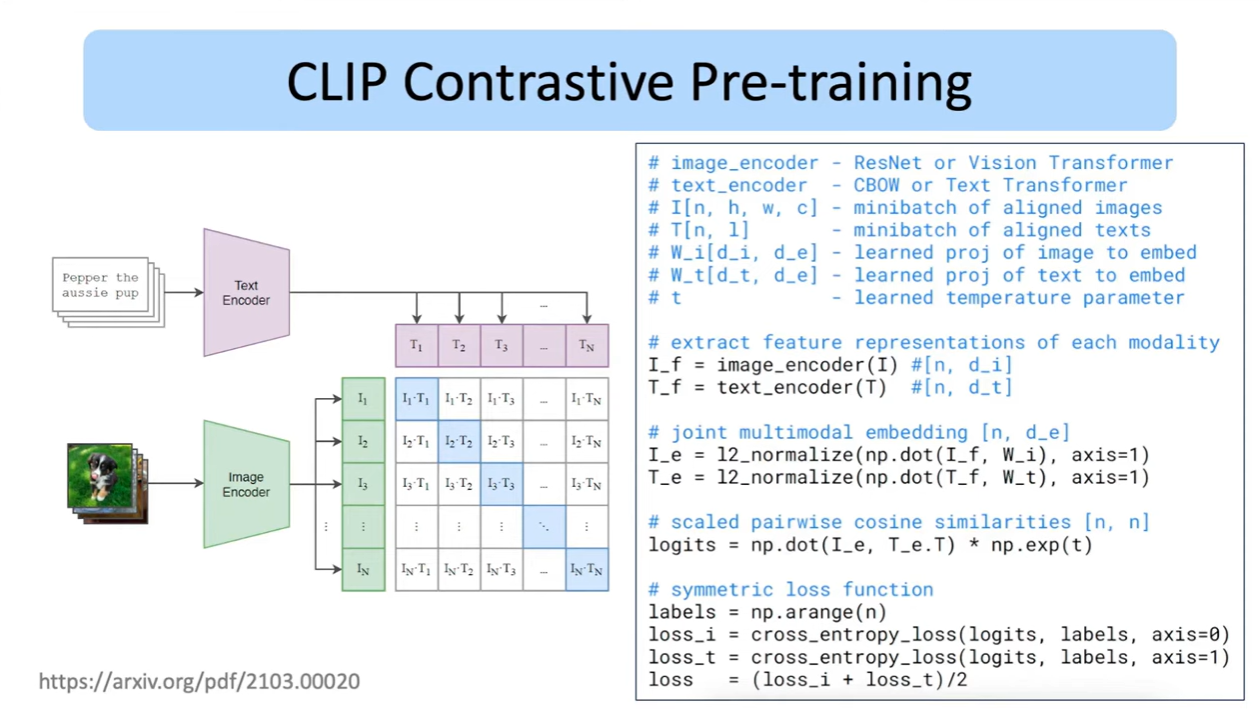

In [ ]:
class CLIP(nn.Module):

    def __init__(self, vocab_size, max_len, n_layers,
                 n_heads, hidden_dim, mlp_dim, embed_dim,
                 img_size, patch_size, img_n_layers,
                 img_n_heads, img_hidden_dim, img_mlp_dim,
                 text_n_layers, text_n_heads, batch_size,
                 text_mlp_dim, text_hidden_dim, ):

        super().__init__()

        self.img_size = img_size
        self.embed_dim = embed_dim
        self.max_len = max_len

        self.img_enc = Image_Encoder(
                img_size = img_size,
                patch_size = patch_size,
                n_layers = img_n_layers,
                n_heads = img_n_heads,
                hidden_dim = img_hidden_dim,
                mlp_dim = img_mlp_dim,
                embed_dim = embed_dim,
        )
        self.txt_enc = Text_Encoder(
                vocab_size = vocab_size,
                max_len = max_len,
                n_layers = text_n_layers,
                n_heads = text_n_heads,
                hidden_dim = text_hidden_dim,
                mlp_dim = text_mlp_dim,
                embed_dim = embed_dim,
        )

        self.gt = torch.arrange(batch_size)                                     # Represents the ground truth 
        

    def forward(self, image, token_ids, attn_mask):
        img_embedding = self.img_enc(image)
        txt_embedding = self.txt_enc(token_ids, attn_mask)
        return img_embedding, txt_embedding


    def Loss_Function(self, img_embedding, txt_embedding):
        norm_img_emb = _l2_norm(img_embedding)
        norm_txt_emb = _l2_norm(txt_embedding)

        matrix = torch.matmul(norm_img_emb, norm_txt_emb.T)                     # We get the similarity matrix

        self.gt = self.gt.to(norm_img_emb.device)                               # Ensures that the device type of both the gt & emb is same

        img_loss = F.cross_entropy(matrix, self.gt, reduction= "mean")          # gt[i] = i always, and thats what the prediction of max(matrix[i]) should be  
        txt_loss = F.cross_entropy(matrix.T, self.gt, reduction= "mean")

        loss = (img_loss + txt_loss) / 2
        return loss